# Stream Processing per l'identificazione di Errori Grammaticali in varie lingue
### Progetto per il corso universitario Technologies for Advanced Programming AA 2021/22
### Samuele Maria Gallina 1000001478

Il progetto si pone l'obiettivo di creare una pipeline per il processing di dati in streaming. <br>
Quello che sarà fatto, detto brevemente, sarà estrarre tweets casuali di qualsiasi lingua per poi successivamente analizzare i testi tramite un tool in Python che si occuperà di calcolare il numero di errori grammaticali all'interno del testo. <br>
Alla fin fine avremmo accesso a una dashboard in Kibana per la data visualization

## Architettura dell'applicazione

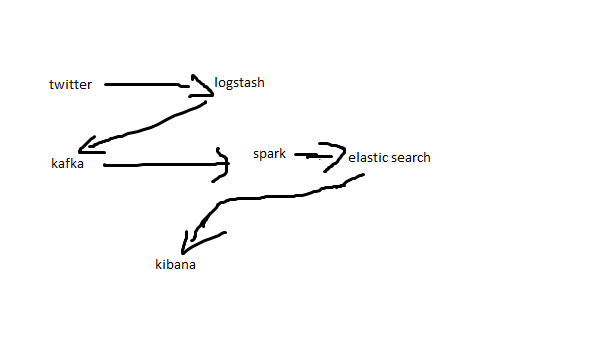

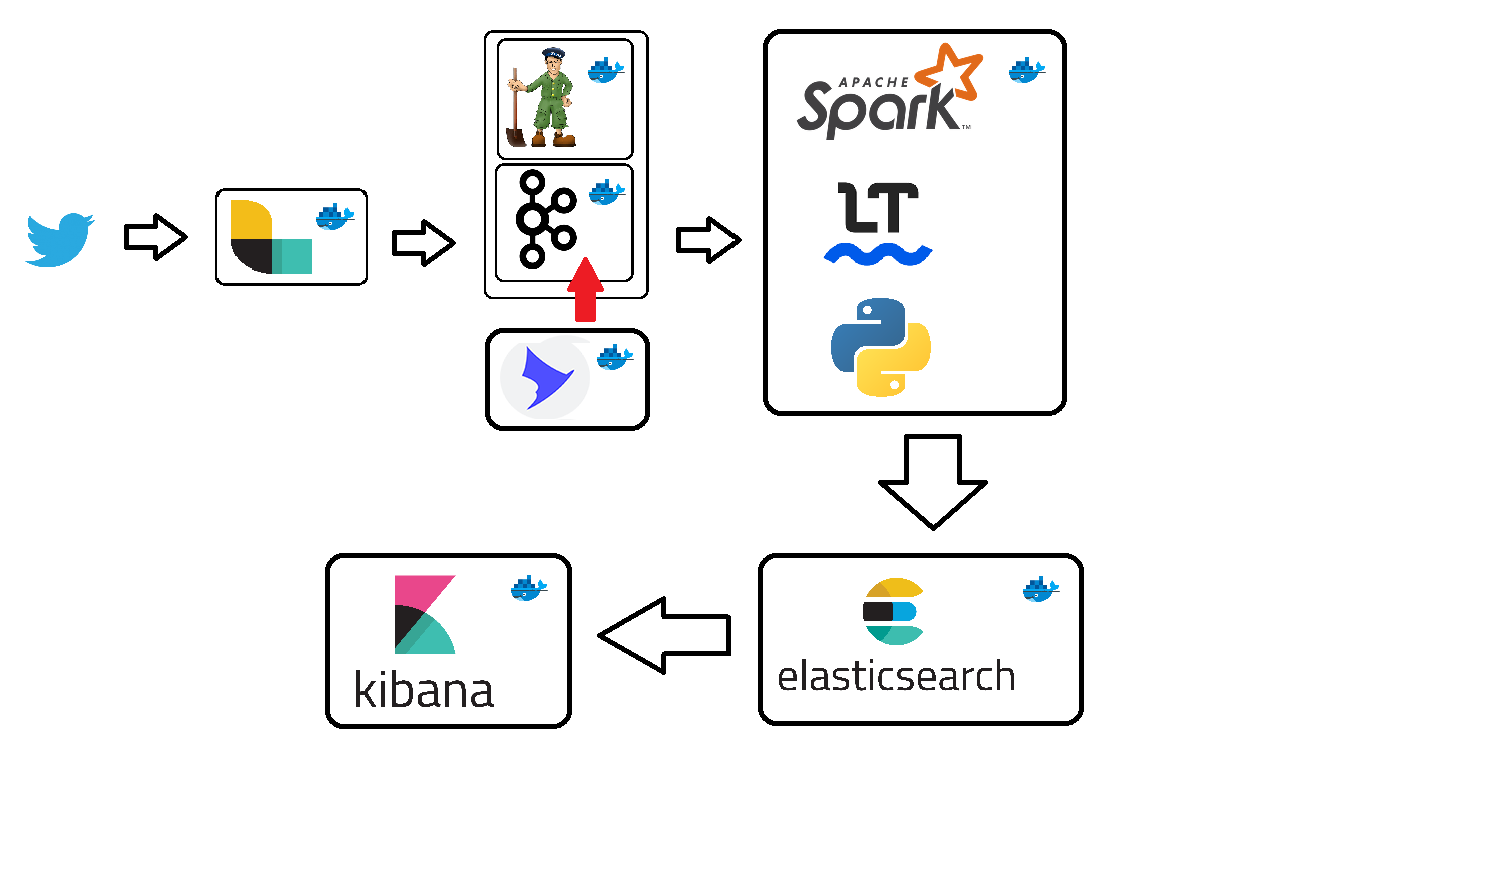

### Obiettivo
L'obiettivo ultimo è creare una dashboard in Kibana che permetta di vedere per ogni lingua il numero medio di errori grammaticali in un testo. <br>
Come sorgente dati si userà Twitter; la sorgente di testi per eccellenza <br>

### Step 0: Ottenere l'accesso alle API di Twitter
Per poter usufruire di questo servizio è necessario possedere un account di Twitter con accesso alle API.
A tal proposito forniamo un link con un tutorial per l'accesso alle API (il tutorial è dell'anno 2022, potrebbe cambiare qualcosa con futuri aggiornamenti) <br>
https://github.com/Gallo00/Tutorial-API-twitter-ita/blob/main/Tutorial.ipynb

### STEP 1: Ottenere dati in streaming da Twitter tramite Logstash
Tramite il tool di data ingestion Logstash intercetteremo il traffico di Twitter per ottenere vari tweets. <br>
Visualizziamo il file logstash.conf

```
input {
  twitter {
      consumer_key => "il tuo consumer key"
      consumer_secret => "il tuo consumer secret"
      oauth_token => "il tuo oauth_token"
      oauth_token_secret => "il tuo oauth_token_secret"

      full_tweet => true # otteniamo tutte le informazioni del tweet
      use_samples => true # selezioniamo tweet random da tutto il mondo 
  }
}

# obiettivo: ottenere il campo text e il campo lang
# con solo la prune per alcuni tweet rimarrebbe il campo "display_text_range"
# forziamo con una remove_field la sua rimozione
filter {
    sleep {
        time => "1"   # Sleep 1 second
        every => 1   # on every 10 events
    }

    prune {
        interpolate => true
        whitelist_names => ["text","lang","created_at"]
    }

    mutate {
        remove_field => ["display_text_range"]
    }
}

# mandiamo in output al topic "tweets" del cluster kafka (inviamo un json)
output {
  # stdout {}

  kafka {
    codec => json
    topic_id => "tweets"
    bootstrap_servers => "kafkaServer:9092"
  }
}
```

L'obiettivo del modulo logstash è, in primis, prendere tweet casuali da Twitter, questo ci è possibile grazie all'opzione <br>
use_samples => true
successivamente tramite una filter faremo in modo di mandare in output solo alcuni campi, successivamente scriviamo i dati (in formato json) sul topic "tweets" presente in kafkaServer sulla porta 9092

Nella stessa cartella chiamata "pipeline" che contiene il file di conf sarà presente il dockerfile relativo a Logstash che ci permetterà di containerizzare il servizio

``` dockerfile
FROM docker.elastic.co/logstash/logstash:8.1.0
```

### STEP 2: canalizzare i dati tramite Kafka

Da Logstash come già detto passeremo i dati al tool Kafka che si occuperà di creare un canale affidabile tra il servizio di data ingestion e il servizio di data processing (Spark) <br>
Quello che faremo sarà sostanzialemente creare 3 container: 
>
> - kafkaserver: è il cuore del servizio, crea un server di ascolto per i dati in entrata
> - zookeeper: si occuperà di gestire dati per KafkaServer
> - kafka-create-topic: da come si può intuire è un container che si occuperà solo di creare i topics (nel nostro caso solo il topic "tweets")
> - webui: fornire una GUI all'utente (usata per debugging)

Nella cartella kafka avremo un dockerfile, un file kafka-manager.sh che semplifica la gestione dei servizi Kafka e una cartella chiamata setup con dentro un file compresso (contiene script e quant'altro per l'utilizzo di Kafka) e una cartella conf con dentro file di configurazione.

``` dockerfile
FROM amazoncorretto:17
LABEL maintainer="Salvo Nicotra"
ENV PATH /opt/kafka/bin:$PATH
ENV KAFKA_DIR "/opt/kafka"
ARG KAFKA_VERSION="2.13-3.1.0"

#RUN apk update && apk add --no-cache bash gcompat

# Installing Kafka
# ADD will automatically extract the file
ADD setup/kafka_${KAFKA_VERSION}.tgz /opt

# Create Sym Link 
RUN ln -s /opt/kafka_${KAFKA_VERSION} ${KAFKA_DIR} 

ADD kafka-manager.sh ${KAFKA_DIR}/bin/kafka-manager
# Copy All conf here
ADD conf/* ${KAFKA_DIR}/config/

ENTRYPOINT [ "kafka-manager" ]
``` 

``` sh
#!/bin/bash
ZK_DATA_DIR=/tmp/zookeeper
ZK_SERVER="localhost"
[[ -z "${KAFKA_ACTION}" ]] && { echo "KAFKA_ACTION required"; exit 1; }
[[ -z "${KAFKA_DIR}" ]] && { echo "KAFKA_DIR missing"; exit 1; }
# ACTIONS start-zk, start-kafka, create-topic, 

echo "Running action ${KAFKA_ACTION} (Kakfa Dir:${KAFKA_DIR}, ZK Server: ${ZK_SERVER})"
case ${KAFKA_ACTION} in
"start-zk")
echo "Starting ZK"
mkdir -p ${ZK_DATA_DIR}; # Data dir is setup in conf/zookeeper.properties
cd ${KAFKA_DIR}
zookeeper-server-start.sh config/zookeeper.properties
;;
"start-kafka")
cd ${KAFKA_DIR}
kafka-server-start.sh config/server.properties
;;
"create-topic")
cd ${KAFKA_DIR}
kafka-topics.sh --create --bootstrap-server 10.0.100.23:9092 --replication-factor 1 --partitions 1 --topic ${KAFKA_TOPIC}
;;
"producer")
cd ${KAFKA_DIR}
#bin/kafka-console-producer.sh --broker-list localhost:9092 --topic test
kafka-console-producer.sh --broker-list 10.0.100.23:9092 --topic ${KAFKA_TOPIC}
;;
"consumer")
cd ${KAFKA_DIR}
kafka-console-consumer.sh --bootstrap-server 10.0.100.23:9092 --topic ${KAFKA_TOPIC} --from-beginning ${KAFKA_CONSUMER_PROPERTIES}
;;
"connect-standalone")
cd ${KAFKA_DIR}
#connect-standalone-twitter.properties mysqlSinkTwitter.conf
touch /tmp/my-test.txt
bin/connect-standalone.sh config/${KAFKA_WORKER_PROPERTIES} config/${KAFKA_CONNECTOR_PROPERTIES}  
;;
"run-class")
cd ${KAFKA_DIR}
bin/kafka-run-class.sh ${KAFKA_CLASS} --bootstrap-server 10.0.100.23:9092 --zookeeper 10.0.100.22:2181 --broker-list 10.0.100.23:9092 
;;
esac
```

### STEP 3: analizzare i dati in streaming con Spark e inviarli a un indice ES
Tramite la libreria PySpark verrà fatta una subscribe al topic "tweets" sul Kafka Server per poter prendere i dati in streaming, analizzarli e successivamente inviare un output a un indice Elastic search. <br>
Gestiamo il ciò con un unico script python chiamato streaming.py

```python
from pprint import pprint
from pyspark.sql import SparkSession
from pyspark.streaming import StreamingContext
from pyspark.sql import types as st
from pyspark.sql.functions import from_json, col, udf

from elasticsearch import Elasticsearch

import language_tool_python

APP_NAME = 'compute_grammar_mistakes'
APP_BATCH_INTERVAL = 1
#tool = language_tool_python.LanguageToolPublicAPI('en') 

elastic_host="https://es01:9200"
elastic_index="tweets"

es_mapping = {
    "mappings": {
        "properties": 
            {
                "created_at": {"type": "date","format": "EEE MMM dd HH:mm:ss Z yyyy"},
                "text": {"type": "text","fielddata": True},
                "lang": {"type": "text","fielddata": True},
                "G_mistakes": {"type":"integer"}
            }
    }
}

es = Elasticsearch(
    hosts=elastic_host,
    ca_certs="/app/certs/ca/ca.crt",
    basic_auth=("elastic", "passwordTAP"), 
) 
# make an API call to the Elasticsearch cluster
# and have it return a response:
response = es.indices.create(
    index=elastic_index,
    body=es_mapping,
    ignore=400 # ignore 400 already exists code
)

if 'acknowledged' in response:
    if response['acknowledged'] == True:
        print ("INDEX MAPPING SUCCESS FOR INDEX:", response['index'])


def get_record_schema():
    return st.StructType([
        st.StructField('text',         st.StringType()),
        st.StructField('lang',         st.StringType()),
        st.StructField('created_at',         st.StringType()),
    ])

def get_mistakes_count(txt,lang):
    # Bisogna fare attenzione alle lingue non supportate dal tool
    # se si provasse a generare il tool con una lingua non supportata ci sarebbe un errore che 
    # farebbe morire il container di spark streaming
    # Se una lingua non è supportata ritorniamo -1

    try:
        tool = language_tool_python.LanguageToolPublicAPI(lang)
        x = tool.check(txt)
        return len(x)
    except:
        return -1

def process_batch(batch_df, batch_id):
    #funzione per scrivere/mandare sull'indice elastic_index i dati
    for idx, row in enumerate(batch_df.collect()):
        row_dict = row.asDict()
        id = f'{batch_id}-{idx}'
        resp = es.index(
            index=elastic_index, 
            id=id, 
            document=row_dict)
        print(resp)

def main():

    spark = SparkSession.builder.appName(APP_NAME).getOrCreate()
    spark.sparkContext.setLogLevel("ERROR")

    schema = get_record_schema()
    
    df = spark.readStream.format('kafka') \
        .option('kafka.bootstrap.servers', 'kafkaserver:9092') \
        .option('subscribe', 'tweets') \
        .option("maxOffsetsPerTrigger",1) \
        .load() \
        .select(from_json(col("value").cast("string"), schema).alias("data")) \
        .selectExpr("data.*")

    #print(type(df))
    #<class 'pyspark.sql.dataframe.DataFrame'>

    # aggiungere colonna a df
    GMC = udf(lambda x, y: get_mistakes_count(x,y),st.IntegerType() )

    df_G = df.withColumn('G_mistakes',GMC(col('text'),col('lang')))

    df_G_filtered = df_G.filter(df_G.G_mistakes > -1) #non ci interessa streammare i contenuti non analizzabili

    
    """
    #per debug
    df_G_filtered.writeStream \
        .format("console") \
        .outputMode("append") \
        .start() \
        .awaitTermination()
    """
    df_G_filtered.writeStream \
        .foreachBatch(process_batch) \
        .start() \
        .awaitTermination()


if __name__ == '__main__': main()
```

Tramite readStream agganciamo l'applicazione Spark al canale Kafka (in particolare facciamo un'iscrizione al topic "tweets"), tramite .option("maxOffsetsPerTrigger",1) facciamo in modo che ogni Batch abbia al massimo 1 record, così semplifichiamo la computazione. <br>
Con le 2 select facciamo in modo che l'input abbia la struttura conservata in "schema".
```python
#schema
st.StructType([
        st.StructField('text',         st.StringType()),
        st.StructField('lang',         st.StringType()),
        st.StructField('created_at',         st.StringType()),
    ])

df = spark.readStream.format('kafka') \
     .option('kafka.bootstrap.servers', 'kafkaserver:9092') \
     .option('subscribe', 'tweets') \
     .option("maxOffsetsPerTrigger",1) \
     .load() \
     .select(from_json(col("value").cast("string"), schema).alias("data")) \
     .selectExpr("data.*")
```

Tramite il tool disponibile grazie alla chiamata a funzione language_tool_python.LanguageToolPublicAPI(lang) calcoliamo il numero di errori grammaticali presenti in stringa (usando poi la funzione tool.check(str) )

Come si vede dal codice non tutte le lingue sono supportate dal tool, per questo la situazione va gestita in qualche modo (bisogna prevedere un'eccezione) <br>

La funzione udf(fun) permette di "convertire" una funzione in modo tale che sia applicabile al Dataframe in streaming di pyspark <br>

Tramite la filter scartiamo gli output che hanno G_mistakes uguale a -1 (dal codice si nota che viene usato questo numero per segnalare il fatto che la lingua non fosse supportata) <br>
```python
# aggiungere colonna a df
GMC = udf(lambda x, y: get_mistakes_count(x,y),st.IntegerType() )

df_G = df.withColumn('G_mistakes',GMC(col('text'),col('lang')))

df_G_filtered = df_G.filter(df_G.G_mistakes > -1) #non ci interessa streammare i contenuti non analizzabili

def get_mistakes_count(txt,lang):
    # Bisogna fare attenzione alle lingue non supportate dal tool
    # se si provasse a generare il tool con una lingua non supportata ci sarebbe un errore che 
    # farebbe morire il container di spark streaming
    # Se una lingua non è supportata ritorniamo -1

    try:
        tool = language_tool_python.LanguageToolPublicAPI(lang)
        x = tool.check(txt)
        return len(x)
    except:
        return -1
```

"Dopo" aver letto i dati in streaming e averli analizzati scriviamo i risultati su un indice Elastic Search. <br>
Come azione preliminare l'indice va creato (o se già esiste bisogna solo stabilire un "collegamento"). <br>
Nella creazione va stabilito un mapping: ovvero segnaliamo la struttura che devono seguire i dati. <br>

Quando stabiliamo la connessione al cluster ElasticSearch specifichiamo un certificato (ottenuto tramite alcuni comandi specificati nel file di docker compose) e le credenziali di accesso. <br>
Dopo aver stabilito la connessione al cluster creiamo l'indice (se già esiste non causa problemi).
```python
elastic_host="https://es01:9200"
elastic_index="tweets"

es_mapping = {
    "mappings": {
        "properties": 
            {
                "created_at": {"type": "date","format": "EEE MMM dd HH:mm:ss Z yyyy"},
                "text": {"type": "text","fielddata": True},
                "lang": {"type": "text","fielddata": True},
                "G_mistakes": {"type":"integer"}
            }
    }
}

es = Elasticsearch(
    hosts=elastic_host,
    ca_certs="/app/certs/ca/ca.crt",
    basic_auth=("elastic", "passwordTAP"), 
) 
# make an API call to the Elasticsearch cluster
# and have it return a response:
response = es.indices.create(
    index=elastic_index,
    body=es_mapping,
    ignore=400 # ignore 400 already exists code
)

if 'acknowledged' in response:
    if response['acknowledged'] == True:
        print ("INDEX MAPPING SUCCESS FOR INDEX:", response['index'])
```

Svolta quest'azione preliminare possiamo passare alla vera e propria scrittura in streaming dei dati. <br>
```python
def process_batch(batch_df, batch_id):
    #funzione per scrivere/mandare sull'indice elastic_index i dati
    for idx, row in enumerate(batch_df.collect()):
        row_dict = row.asDict()
        id = f'{batch_id}-{idx}'
        resp = es.index(
            index=elastic_index, 
            id=id, 
            document=row_dict)
        print(resp)
        
df_G_filtered.writeStream \
    .foreachBatch(process_batch) \
    .start() \
    .awaitTermination()
```

Per creare il container lo script python è conservato insieme un dockerfile che si occupa di scaricare le librerie necessarie e fare una spark-submit dello script python per poterlo utilizzare nell'applicativo Spark. <br>
```dockerfile
FROM jupyter/pyspark-notebook:spark-3.1.1

RUN pip install language-tool-python elasticsearch
RUN pip3 install pyspark numpy 

WORKDIR /app

COPY ./code .

ENTRYPOINT ["spark-submit", "--packages", "org.apache.spark:spark-sql-kafka-0-10_2.12:3.1.1", "--master", "local[*]", "streaming.py"]
```

### STEP 4: indicizzare i dati con Elastic Search
Per quanto riguarda Elastic Search, il tutto è stato gestito all'interno del file docker compose. <br>
Di seguito la configurazione del container es01 che gestisce il cluster.<br>
```yaml
    es01:
      depends_on:
        setup:
          condition: service_healthy
      image: docker.elastic.co/elasticsearch/elasticsearch:${STACK_VERSION}
      container_name: es01 #new
      volumes:
        - certs:/usr/share/elasticsearch/config/certs
        - esdata01:/usr/share/elasticsearch/data
      ports:
        - ${ES_PORT}:9200
      environment:
        - node.name=es01
        - cluster.name=${CLUSTER_NAME}
        - cluster.initial_master_nodes=es01
        - ELASTIC_PASSWORD=${ELASTIC_PASSWORD}
        - bootstrap.memory_lock=true
        - xpack.security.enabled=true
        - xpack.security.http.ssl.enabled=true
        - xpack.security.http.ssl.key=certs/es01/es01.key
        - xpack.security.http.ssl.certificate=certs/es01/es01.crt
        - xpack.security.http.ssl.certificate_authorities=certs/ca/ca.crt
        - xpack.security.http.ssl.verification_mode=certificate
        - xpack.security.transport.ssl.enabled=true
        - xpack.security.transport.ssl.key=certs/es01/es01.key
        - xpack.security.transport.ssl.certificate=certs/es01/es01.crt
        - xpack.security.transport.ssl.certificate_authorities=certs/ca/ca.crt
        - xpack.security.transport.ssl.verification_mode=certificate
        - xpack.license.self_generated.type=${LICENSE}
        - "ES_JAVA_OPTS=-Xms1g -Xmx1g"
      # mem_limit: ${MEM_LIMIT}
      ulimits:
        memlock:
          soft: -1
          hard: -1
      healthcheck:
        test:
          [
            "CMD-SHELL",
            "curl -s --cacert config/certs/ca/ca.crt https://localhost:9200 | grep -q 'missing authentication credentials'",
          ]
        interval: 10s
        timeout: 10s
        retries: 120
      networks: 
        - tap
```

Tramite i volumi gestiamo il certificato per la sicurezza e uno spazio in cui conservare i dati. <br>
L'immagine viene pullata da docker hub.<br>
Nella configurazione si può notare una dipendenza relativa a un container chiamato setup, esso compie alcune azioni preliminari per il corretto avviamento dei container es01 e kibana.

### STEP 5: data visualization con Kibana
Anche il servizio Kibana lo gestiamo molto agevolmente tramite il file docker compose, usiamo però anche un altro file chiamata kibana.yml, all'interno vi sono dei parametri come ad esempio password ecc. <br>

kibana.yml
```yaml
# For more configuration options see the configuration guide for Kibana in
# https://www.elastic.co/guide/index.html

# =================== System: Kibana Server ===================
# Kibana is served by a back end server. This setting specifies the port to use.
server.port: 5601

# Specifies the address to which the Kibana server will bind. IP addresses and host names are both valid values.
# The default is 'localhost', which usually means remote machines will not be able to connect.
# To allow connections from remote users, set this parameter to a non-loopback address.
server.host: "0.0.0.0"

# Enables you to specify a path to mount Kibana at if you are running behind a proxy.
# Use the `server.rewriteBasePath` setting to tell Kibana if it should remove the basePath
# from requests it receives, and to prevent a deprecation warning at startup.
# This setting cannot end in a slash.
#server.basePath: ""

# Specifies whether Kibana should rewrite requests that are prefixed with
# `server.basePath` or require that they are rewritten by your reverse proxy.
# Defaults to `false`.
#server.rewriteBasePath: false

# Specifies the public URL at which Kibana is available for end users. If
# `server.basePath` is configured this URL should end with the same basePath.
#server.publicBaseUrl: ""

# The maximum payload size in bytes for incoming server requests.
server.maxPayload: 1048576

# The Kibana server's name. This is used for display purposes.
server.name: "kibana"

# =================== System: Kibana Server (Optional) ===================
# Enables SSL and paths to the PEM-format SSL certificate and SSL key files, respectively.
# These settings enable SSL for outgoing requests from the Kibana server to the browser.
#server.ssl.enabled: false
#server.ssl.certificate: /path/to/your/server.crt
#server.ssl.key: /path/to/your/server.key

# =================== System: Elasticsearch ===================
# The URLs of the Elasticsearch instances to use for all your queries.
elasticsearch.hosts: ["https://es01:9200"]

# If your Elasticsearch is protected with basic authentication, these settings provide
# the username and password that the Kibana server uses to perform maintenance on the Kibana
# index at startup. Your Kibana users still need to authenticate with Elasticsearch, which
# is proxied through the Kibana server.
elasticsearch.username: "elastic"
elasticsearch.password: "passwordTAP"

# Kibana can also authenticate to Elasticsearch via "service account tokens".
# Service account tokens are Bearer style tokens that replace the traditional username/password based configuration.
# Use this token instead of a username/password.
# elasticsearch.serviceAccountToken: "my_token"

# Time in milliseconds to wait for Elasticsearch to respond to pings. Defaults to the value of
# the elasticsearch.requestTimeout setting.
elasticsearch.pingTimeout: 15000

# Time in milliseconds to wait for responses from the back end or Elasticsearch. This value
# must be a positive integer.
elasticsearch.requestTimeout: 30000

# The maximum number of sockets that can be used for communications with elasticsearch.
# Defaults to `Infinity`.
elasticsearch.maxSockets: 1024

# Specifies whether Kibana should use compression for communications with elasticsearch
# Defaults to `false`.
elasticsearch.compression: false

# List of Kibana client-side headers to send to Elasticsearch. To send *no* client-side
# headers, set this value to [] (an empty list).
#elasticsearch.requestHeadersWhitelist: [ authorization ]

# Header names and values that are sent to Elasticsearch. Any custom headers cannot be overwritten
# by client-side headers, regardless of the elasticsearch.requestHeadersWhitelist configuration.
#elasticsearch.customHeaders: {}

# Time in milliseconds for Elasticsearch to wait for responses from shards. Set to 0 to disable.
elasticsearch.shardTimeout: 30000

# =================== System: Elasticsearch (Optional) ===================
# These files are used to verify the identity of Kibana to Elasticsearch and are required when
# xpack.security.http.ssl.client_authentication in Elasticsearch is set to required.
#elasticsearch.ssl.certificate: /path/to/your/client.crt
#elasticsearch.ssl.key: /path/to/your/client.key

# Enables you to specify a path to the PEM file for the certificate
# authority for your Elasticsearch instance.
#elasticsearch.ssl.certificateAuthorities: [ "/path/to/your/CA.pem" ]

# To disregard the validity of SSL certificates, change this setting's value to 'none'.
#elasticsearch.ssl.verificationMode: full

# =================== System: Logging ===================
# Set the value of this setting to off to suppress all logging output, or to debug to log everything. Defaults to 'info'
logging.root.level: debug

# Enables you to specify a file where Kibana stores log output.
# logging.appenders.default:
#  type: file
#  fileName: /var/logs/kibana.log
#  layout:
#    type: json

# Logs queries sent to Elasticsearch.
# logging.loggers:
#  - name: elasticsearch.query
#    level: debug

# Logs http responses.
#logging.loggers:
#  - name: http.server.response
#    level: debug

# Logs system usage information.
#logging.loggers:
#  - name: metrics.ops
#    level: debug

# =================== System: Other ===================
# The path where Kibana stores persistent data not saved in Elasticsearch. Defaults to data
#path.data: data

# Specifies the path where Kibana creates the process ID file.
#pid.file: /run/kibana/kibana.pid

# Set the interval in milliseconds to sample system and process performance
# metrics. Minimum is 100ms. Defaults to 5000ms.
#ops.interval: 5000

# Specifies locale to be used for all localizable strings, dates and number formats.
# Supported languages are the following: English (default) "en", Chinese "zh-CN", Japanese "ja-JP", French "fr-FR".
#i18n.locale: "en"

# =================== Frequently used (Optional)===================

# =================== Saved Objects: Migrations ===================
# Saved object migrations run at startup. If you run into migration-related issues, you might need to adjust these settings.

# The number of documents migrated at a time.
# If Kibana can't start up or upgrade due to an Elasticsearch `circuit_breaking_exception`,
# use a smaller batchSize value to reduce the memory pressure. Defaults to 1000 objects per batch.
#migrations.batchSize: 1000

# The maximum payload size for indexing batches of upgraded saved objects.
# To avoid migrations failing due to a 413 Request Entity Too Large response from Elasticsearch.
# This value should be lower than or equal to your Elasticsearch cluster’s `http.max_content_length`
# configuration option. Default: 100mb
#migrations.maxBatchSizeBytes: 100mb

# The number of times to retry temporary migration failures. Increase the setting
# if migrations fail frequently with a message such as `Unable to complete the [...] step after
# 15 attempts, terminating`. Defaults to 15
#migrations.retryAttempts: 15

# =================== Search Autocomplete ===================
# Time in milliseconds to wait for autocomplete suggestions from Elasticsearch.
# This value must be a whole number greater than zero. Defaults to 1000ms
#unifiedSearch.autocomplete.valueSuggestions.timeout: 1000

# Maximum number of documents loaded by each shard to generate autocomplete suggestions.
# This value must be a whole number greater than zero. Defaults to 100_000
#unifiedSearch.autocomplete.valueSuggestions.terminateAfter: 100000

```

container kibana
```yaml
    kibana:
      depends_on:
        es01:
          condition: service_healthy
      image: docker.elastic.co/kibana/kibana:${STACK_VERSION}
      container_name: kibana #new
      volumes:
        - certs:/usr/share/kibana/config/certs
        - kibanadata:/usr/share/kibana/data
        - ./ES_Kibana/elasticsearch/configs/kibana.yml:/usr/share/kibana/config/kibana.yml
      ports:
        - ${KIBANA_PORT}:5601
      environment:
        - SERVERNAME=kibana
        - ELASTICSEARCH_HOSTS=https://es01:9200
        - ELASTICSEARCH_USERNAME=kibana_system
        - ELASTICSEARCH_PASSWORD=${KIBANA_PASSWORD}
        - ELASTICSEARCH_SSL_CERTIFICATEAUTHORITIES=config/certs/ca/ca.crt
      mem_limit: ${MEM_LIMIT}
      healthcheck:
        test:
          [
            "CMD-SHELL",
            "curl -s -I http://localhost:5601 | grep -q 'HTTP/1.1 302 Found'",
          ]
        interval: 20s
        timeout:  20s
        retries: 120
      networks: 
            - tap
```

### Variabili d'ambiente
Per l'uso dei container kibana ed es01 sono state conservate alcune variabili d'ambiente nel seguente file .env

```env
# Password for the 'elastic' user (at least 6 characters)
ELASTIC_PASSWORD=passwordTAP

# Password for the 'kibana_system' user (at least 6 characters)
KIBANA_PASSWORD=passwordTAP

# Version of Elastic products
STACK_VERSION=8.2.2

# Set the cluster name
CLUSTER_NAME=docker-cluster

# Set to 'basic' or 'trial' to automatically start the 30-day trial
LICENSE=basic
#LICENSE=trial

# Port to expose Elasticsearch HTTP API to the host
ES_PORT=9200
#ES_PORT=127.0.0.1:9200

# Port to expose Kibana to the host
KIBANA_PORT=5601
#KIBANA_PORT=80

# Increase or decrease based on the available host memory (in bytes)
MEM_LIMIT=2147483648

# Project namespace (defaults to the current folder name if not set)
#COMPOSE_PROJECT_NAME=myproject
```

## Il file docker-compose.yml
Possiamo ora riportare il file docker compose che si occuperà di orchestrare i vari container per l'avviamento dell'applicazione di stream processing. <br>

Alcune info riassuntive utili:
>- I container solo collegati tra loro tramite una network chiamata "tap"
>- Sono state definite diverse dipendenze tra alcuni container per garantire un corretto workflow
>- Sono stati utilizzati dei volumi per la gestione dei certificati, delle configurazioni e dei dati (per renderli persistenti)

```yaml
version: '3.8'

services: 


    #-------------------------------#
    # Spark 🧮                      #
    #-------------------------------#
    #sembra dare problemi nel creare la connessione all'indice elastic search
    #forse è perchè quando cerca di connettersi l'indice non è ancora stato creato, potremmo dover mettere una dipendenza
    #oppure modificare il codice python affinchè se fallisce la connessione la riprova qualche secondo dopo
    spark:
        build: 
            context: spark/streaming
        container_name: spark-streaming
        networks:
          - tap
        volumes:
          - certs:/app/certs
        depends_on:
          zookeeper:
            condition: service_started 
          kafkaserver:
            condition: service_started
          setup:
            condition: service_completed_successfully
          es01:
            condition: service_started
          kibana:
            condition: service_started
    #-------------------------------#
    # Zookeeper 🦓                 #
    #-------------------------------#
    zookeeper:
        build:
           context: kafka
           dockerfile: Dockerfile
        image: projtap:kafka
        container_name: kafkaZK
        ports:
            - "2181:2181"
        environment:
            KAFKA_ACTION: start-zk
            ZOOKEEPER_CLIENT_PORT: 2181
            ZOOKEEPER_SERVER_ID: "1"
        networks: 
          tap:
            ipv4_address: 10.0.100.22

    #-------------------------------#
    # Kafka Server 📨               #
    #-------------------------------#

    kafkaserver:
        build:
           context: kafka
           dockerfile: Dockerfile
        container_name: kafkaserver
        hostname: kafkaserver
        depends_on:
          - zookeeper
        ports:
          - "9092:9092"
        environment:
          KAFKA_ZOOKEEPER_CONNECT: zookeeper:2181
          KAFKA_ADVERTISED_LISTENERS: PLAINTEXT://kafkaserver:9092
          KAFKA_DEFAULT_REPLICATION_FACTOR: 1
          KAFKA_OFFSETS_TOPIC_REPLICATION_FACTOR: 1
          KAFKA_TRANSACTION_STATE_LOG_REPLICATION_FACTOR: 1
          KAFKA_ACTION: start-kafka
        networks: 
          tap:
           ipv4_address: 10.0.100.23

    #-------------------------------#
    # Kafka User interface  🖥️      #
    #-------------------------------#
    webui:
        image: provectuslabs/kafka-ui:latest
        container_name: kafkaWebUI
        environment:
            KAFKA_CLUSTERS_0_NAME: cluster_tweets
            KAFKA_CLUSTERS_0_ZOOKEEPER: 10.0.100.22:2181
            KAFKA_CLUSTERS_0_BOOTSTRAPSERVERS: 10.0.100.23:9092
        ports: 
            - "8080:8080"
        depends_on: 
            - kafkaserver
        networks: 
            - tap
    
    #-------------------------------#
    # Kafka create topics 🚀        #
    #-------------------------------#
    kafka-create-topic:
        build:
            context: kafka
            dockerfile: Dockerfile
        container_name: kafka-create-topic
        image: projtap:kafka
        depends_on: 
            - kafkaserver
        environment:
            KAFKA_ACTION: create-topic
            KAFKA_SERVER: 10.0.100.23
            KAFKA_TOPIC: tweets 
        networks: 
          tap:
            ipv4_address: 10.0.100.24

    #-------------------------------#
    # Logstash 🎬                   #
    #-------------------------------#
    logstash:
        build: 
            context: logstash
            dockerfile: Dockerfile
        image: projtap:logstash
        container_name: logstash
        depends_on: 
            - kafkaserver
        networks: 
            - tap
        volumes:
            - $PWD/logstash/pipeline/:/usr/share/logstash/pipeline/


    #-------------------------------#
    # SETUP ES e KIBANA🎬           #
    #-------------------------------#
    setup:
      image: docker.elastic.co/elasticsearch/elasticsearch:${STACK_VERSION}
      container_name: setupESKibana #new
      volumes:
        - certs:/usr/share/elasticsearch/config/certs
      user: "0"
      command: >
        bash -c '
          if [ x${ELASTIC_PASSWORD} == x ]; then
            echo "Set the ELASTIC_PASSWORD environment variable in the .env file";
            exit 1;
          elif [ x${KIBANA_PASSWORD} == x ]; then
            echo "Set the KIBANA_PASSWORD environment variable in the .env file";
            exit 1;
          fi;
          if [ ! -f config/certs/ca.zip ]; then
            echo "Creating CA";
            bin/elasticsearch-certutil ca --silent --pem -out config/certs/ca.zip;
            unzip config/certs/ca.zip -d config/certs;
          fi;
          if [ ! -f config/certs/certs.zip ]; then
            echo "Creating certs";
            echo -ne \
            "instances:\n"\
            "  - name: es01\n"\
            "    dns:\n"\
            "      - es01\n"\
            "      - localhost\n"\
            "    ip:\n"\
            "      - 127.0.0.1\n"\
            > config/certs/instances.yml;
            bin/elasticsearch-certutil cert --silent --pem -out config/certs/certs.zip --in config/certs/instances.yml --ca-cert config/certs/ca/ca.crt --ca-key config/certs/ca/ca.key;
            unzip config/certs/certs.zip -d config/certs;
          fi;
          echo "Setting file permissions"
          chown -R root:root config/certs;
          find . -type d -exec chmod 750 \{\} \;;
          find . -type f -exec chmod 640 \{\} \;;
          echo "Waiting for Elasticsearch availability";
          until curl -s --cacert config/certs/ca/ca.crt https://es01:9200 | grep -q "missing authentication credentials"; do sleep 30; done;
          echo "Setting kibana_system password";
          until curl -s -X POST --cacert config/certs/ca/ca.crt -u elastic:${ELASTIC_PASSWORD} -H "Content-Type: application/json" https://es01:9200/_security/user/kibana_system/_password -d "{\"password\":\"${KIBANA_PASSWORD}\"}" | grep -q "^{}"; do sleep 10; done;
          echo "All done!";
          chmod 777 -R config/certs
        '
      healthcheck:
        test: ["CMD-SHELL", "[ -f config/certs/es01/es01.crt ]"]
        interval: 1s
        timeout: 5s
        retries: 120
      networks: 
            - tap

    #-------------------------------#
    # ELASTIC SEARCH  🎬           #
    #-------------------------------#
    es01:
      depends_on:
        setup:
          condition: service_healthy
      image: docker.elastic.co/elasticsearch/elasticsearch:${STACK_VERSION}
      container_name: es01 #new
      volumes:
        - certs:/usr/share/elasticsearch/config/certs
        - esdata01:/usr/share/elasticsearch/data
      ports:
        - ${ES_PORT}:9200
      environment:
        - node.name=es01
        - cluster.name=${CLUSTER_NAME}
        - cluster.initial_master_nodes=es01
        - ELASTIC_PASSWORD=${ELASTIC_PASSWORD}
        - bootstrap.memory_lock=true
        - xpack.security.enabled=true
        - xpack.security.http.ssl.enabled=true
        - xpack.security.http.ssl.key=certs/es01/es01.key
        - xpack.security.http.ssl.certificate=certs/es01/es01.crt
        - xpack.security.http.ssl.certificate_authorities=certs/ca/ca.crt
        - xpack.security.http.ssl.verification_mode=certificate
        - xpack.security.transport.ssl.enabled=true
        - xpack.security.transport.ssl.key=certs/es01/es01.key
        - xpack.security.transport.ssl.certificate=certs/es01/es01.crt
        - xpack.security.transport.ssl.certificate_authorities=certs/ca/ca.crt
        - xpack.security.transport.ssl.verification_mode=certificate
        - xpack.license.self_generated.type=${LICENSE}
        - "ES_JAVA_OPTS=-Xms1g -Xmx1g"
      # mem_limit: ${MEM_LIMIT}
      ulimits:
        memlock:
          soft: -1
          hard: -1
      healthcheck:
        test:
          [
            "CMD-SHELL",
            "curl -s --cacert config/certs/ca/ca.crt https://localhost:9200 | grep -q 'missing authentication credentials'",
          ]
        interval: 10s
        timeout: 10s
        retries: 120
      networks: 
        - tap


    #-------------------------------#
    # KIBANA🎬                      #
    #-------------------------------#
    kibana:
      depends_on:
        es01:
          condition: service_healthy
      image: docker.elastic.co/kibana/kibana:${STACK_VERSION}
      container_name: kibana #new
      volumes:
        - certs:/usr/share/kibana/config/certs
        - kibanadata:/usr/share/kibana/data
        - ./ES_Kibana/elasticsearch/configs/kibana.yml:/usr/share/kibana/config/kibana.yml
      ports:
        - ${KIBANA_PORT}:5601
      environment:
        - SERVERNAME=kibana
        - ELASTICSEARCH_HOSTS=https://es01:9200
        - ELASTICSEARCH_USERNAME=kibana_system
        - ELASTICSEARCH_PASSWORD=${KIBANA_PASSWORD}
        - ELASTICSEARCH_SSL_CERTIFICATEAUTHORITIES=config/certs/ca/ca.crt
      mem_limit: ${MEM_LIMIT}
      healthcheck:
        test:
          [
            "CMD-SHELL",
            "curl -s -I http://localhost:5601 | grep -q 'HTTP/1.1 302 Found'",
          ]
        interval: 20s
        timeout:  20s
        retries: 120
      networks: 
            - tap

networks:
    tap:
        name: tap
        driver: bridge

#volumi per ES e Kibana e Spark
volumes:
  certs:
    driver: local
  esdata01:
    driver: local
  kibanadata:
    driver: local
```

### Note sulle dipendenze
Scrivere <br>
```yaml
depends_on: 
    - containerGiacomo
```
E' equivalente a scrivere <br>
```yaml
depends_on: 
     containerGiacomo:
            condition: service_started 
```
Ovvero il container con la depends_on non si avvierà finchè il containerGiacomo non si sarà avviato <br>
Come condition possiamo specificare altre 2 opzioni che sono 
>- service_healthy: il servizio è sano, siamo noi nella configurazione dell'opzione healthcheck a stabilire cosa significa sano
>- service_completed_successfully: il servizio deve aver finito il suo lavoro con successo

Reference: https://docs.docker.com/compose/compose-file/#long-syntax-1